# Porównywanie szyfrów blokowych

### Importowanie bibliotek
Ten fragment kodu importuje bibliotekę hashlib, bibliotekę os, bibliotekę time oraz bibliotekę matplotlib.pyplot.

- os jest biblioteką, która udostępnia wiele funkcji związanych z systemem operacyjnym, takich jak np. operacje na plikach i katalogach.
- time to biblioteka, która umożliwia operowanie czasem.
- Crypto.Cipher umożliwia szyfrowanie i deszyfrowanie danych przy użyciu algorytmu AES
- matplotlib.pyplot to biblioteka, która umożliwia tworzenie wykresów i grafik.
- prettytable to biblioteka, która służy do wyświetlania tabel w konsoli

In [2]:
import os
import time
from Crypto.Cipher import AES
import matplotlib.pyplot as plt
from prettytable import PrettyTable

---

### Tworzenie plików
Tworzymy trzy pliki o rozmiarach 1, 5 i 10 megabajtów w katalogu "files". Funkcja create_file służy do generowania plików o określonym rozmiarze, a następnie jest wywoływana trzy razy w pętli for z argumentami 1, 5 i 10, aby utworzyć trzy pliki o różnych rozmiarach. Dodatkowo w funkcji create_file istnieje opcjonalny argument "amount_1_bin", który służy do zdefiniowania, ile znaków o 1 bicie pojawi się w pliku wynikowym.

In [3]:
file_samples = [1, 5, 10]
files_directory = 'files'
file_names = [f"./{files_directory}/{file_name}MB.txt" for file_name in file_samples]

def create_file(size_in_mb, directory=files_directory, amount_1_bin=0):
    size_in_bytes = size_in_mb * 1024 * 1024

    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(f'{directory}/{size_in_mb}MB.txt', 'wb') as f:
        f.write(b'\0' * (size_in_bytes - amount_1_bin))
        f.write(b'\1' * amount_1_bin)

for sample in file_samples:
    create_file(sample)

---

### Wyliczanie czasów działania algorytmów
Liczymy czas, jaki zajmuje poszczególnym algorytmom na skrócenie każdego z trzech plików. Każdy pomiar wykonujemy 30 razy i go uśredniamy w celu zachowania transparentności wyników.

In [4]:
def encrypt_with_mode_time(filename, key, mode):
    with open(filename, 'rb') as f:
        msg = f.read()

    cipher = AES.new(key, mode)

    start = time.time()
    msg_en = cipher.encrypt(msg)
    end = time.time()

    return end - start

ctr_time = []
cbc_time = []
ecb_time = []

key = os.urandom(16)
for file_name in file_names:
    ctr_sum, cbc_sum, ecb_sum = 0, 0, 0

    for _ in range(30):
        ctr_sum += encrypt_with_mode_time(file_name, key, AES.MODE_CTR)
        cbc_sum += encrypt_with_mode_time(file_name, key, AES.MODE_CBC)
        ecb_sum += encrypt_with_mode_time(file_name, key, AES.MODE_ECB)

    ctr_time.append(ctr_sum/30)
    cbc_time.append(cbc_sum/30)
    ecb_time.append(ecb_sum/30)

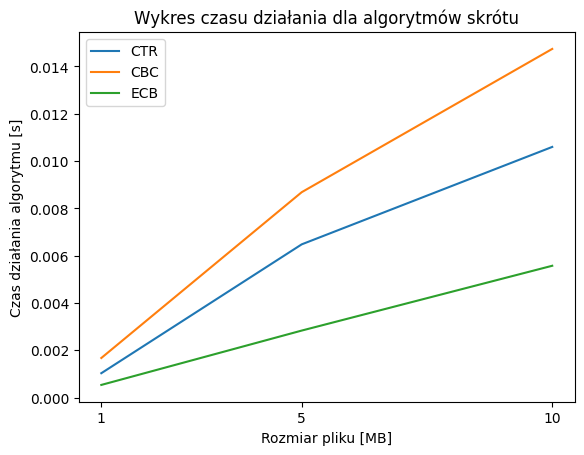

In [5]:
x = file_samples.copy()

plt.plot(x, ctr_time, label="CTR")
plt.plot(x, cbc_time, label="CBC")
plt.plot(x, ecb_time, label="ECB")

plt.xticks(x)
plt.xlabel('Rozmiar pliku [MB]')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Wykres czasu działania dla algorytmów skrótu')
plt.legend()
plt.show()

Jak widać, najszybciej radzi sobie ECB. Nieco wolniej radzą sobie algorytmy CTR oraz CBC. Różnice w wydajności algorytmów CTR, CBC i ECB mogą wynikać z różnic w ich działaniu.


- ECB (Electronic Codebook) - W przypadku tego trybu szyfrowania, dane są dzielone na bloki i każdy blok jest niezależnie szyfrowany tym samym kluczem. Ten tryb jest prosty, ale ma pewne wady. Powtarzające się bloki w danych wejściowych będą miały takie same bloki w danych wyjściowych, co prowadzi do utraty poufności i pozwala na analizę wzorców. ECB jest prosty w implementacji, ale nie jest zalecany do zastosowań, gdzie poufność jest ważna.

- CBC (Cipher Block Chaining) - Ten tryb działa poprzez XOR-owanie poprzedniego bloku z bieżącym blokiem przed jego zaszyfrowaniem. Otrzymany wynik jest następnie używany jako wejście do zaszyfrowania kolejnego bloku. Ta technika wprowadza zależność między blokami, co utrudnia analizę wzorców i poprawia poufność. Jednak proces XOR-owania i potrzeba przesyłania wektora inicjalizacyjnego (IV) dla każdego bloku może wpływać na wydajność, co sprawia, że jest nieco wolniejszy od ECB.

- CTR (Counter) - Ten tryb działa w sposób niezależny dla każdego bloku. Zamiast XOR-owania z poprzednim blokiem, jest wykorzystywany licznik, który jest szyfrowany z użyciem klucza. Licznik jest zwiększany dla każdego bloku, a wynik jest XOR-owany z danymi wejściowymi, co daje dane wyjściowe. Ten tryb jest równoległy, co oznacza, że bloki mogą być szyfrowane niezależnie, co prowadzi do potencjalnie szybszych operacji w porównaniu do CBC. Ponadto, CTR nie wymaga przesyłania IV dla każdego bloku, co może wpływać na wydajność.


Dlatego możliwe jest, że algorytm ECB jest najszybszy, ponieważ nie ma dodatkowych operacji XOR-owania ani potrzeby przesyłania wektora inicjalizacyjnego. Algorytmy CTR i CBC, choć bardziej bezpieczne, wymagają dodatkowych operacji, które mogą wpływać na wydajność i dlatego są nieco wolniejsze.

---

### Analiza algorytmów przy zmianie bitów klucza lub wiadomości

 W programie definiujemy dwie funkcje. Jedna służy do stworzenia dwóch losowych sekwencji, które różnią się jednym bitem. Druga służy do porównywania dwóch danych na wejściu, która sprawdza ile % bitów w dwóch wiadomościach się różnią.

In [64]:
def generate_two_messages(size):
    data = os.urandom(size)
    data_modified = bytearray(data)
    data_modified[0] += 1

    return data, data_modified

def compare_messages(msg1, msg2):
    msg1_list = [bit for bit in msg1]
    msg2_list = [bit for bit in msg2]

    result = 0
    for bit1, bit2 in zip(msg1_list, msg2_list):
        if bit1 == bit2:
            result += 1

    return result / len(msg1) * 100

#### Analiza algorytmów przy zmianie bitów w wiadomościach

Program dla każdego algorytmu generuje dwie wiadomości, które różnią się jednym bitem, a następnie szyfruje obie wiadomości, używając tego samego klucza oraz używając różnych algorytmów. Na końcu wyniki są prezentowane w tabeli.

In [62]:
def analysis_cipher_msg(size, mode):
    key = os.urandom(16)
    cipher = AES.new(key, mode)

    percent_sum = 0

    for _ in range(30):
        msg1, msg2 = generate_two_messages(size)
        msg1_en = cipher.encrypt(msg1)
        msg2_en = cipher.encrypt(msg2)
        percent = compare_messages(msg1_en, msg2_en)
        percent_sum += percent

    return percent_sum / 30

table = PrettyTable()
table.field_names = ["Rozmiar danych", "Szyfr ECB", "Szyfr CBC", "Szyfr CTR"]

for sample in file_samples:
    data_ecb = analysis_cipher_msg(sample * 1024, AES.MODE_ECB)
    data_cbc = analysis_cipher_msg(sample * 1024, AES.MODE_CBC)
    data_ctr = analysis_cipher_msg(sample * 1024, AES.MODE_CTR)

    table.add_row([f"{sample}MB", f"{round(data_ecb, 2)}%", f"{round(data_cbc, 2)}%", f"{round(data_ctr, 2)}%"])

print(table.get_string())

+----------------+-----------+-----------+-----------+
| Rozmiar danych | Szyfr ECB | Szyfr CBC | Szyfr CTR |
+----------------+-----------+-----------+-----------+
|      1MB       |   98.44%  |   0.39%   |   0.42%   |
|      5MB       |   99.69%  |   0.37%   |   0.36%   |
|      10MB      |   99.84%  |   0.39%   |   0.38%   |
+----------------+-----------+-----------+-----------+


Wyniki analizy przedstawionej w tabeli są związane z charakterystykami i właściwościami poszczególnych algorytmów szyfrowania: ECB, CBC i CTR. Oto kilka czynników, które mogą wpływać na otrzymane wyniki:


- **ECB (Electronic Codebook)**: ECB jest jednym z najprostszych algorytmów szyfrowania blokowego, który dzieli dane na bloki o stałym rozmiarze i każdy blok jest szyfrowany niezależnie od siebie. Z tego powodu, jeśli zmienimy pojedynczy bit w bloku danych, cały blok zostanie zaszyfrowany inaczej. W rezultacie zmiana jednego bitu w oryginalnej wiadomości powoduje znaczną zmianę w zaszyfrowanej wiadomości, co jest odzwierciedlone wysokim odsetkiem zmienionych danych w tabeli.

- **CBC (Cipher Block Chaining)**: CBC wykorzystuje mechanizm sprzęgania bloków, w którym każdy blok jest operacją XORowany z poprzednio zaszyfrowanym blokiem przed szyfrowaniem. Ta technika sprzęgania bloków sprawia, że zmiana jednego bitu w jednym bloku wpływa na zaszyfrowane bloki po nim. Jednak efekt kaskadowy nie jest tak znaczący jak w przypadku ECB, co wynika z niższego odsetka zmienionych danych w tabeli dla CBC.

- **CTR (Counter)**: CTR jest trybem pracy, który przekształca szyfrowanie blokowe w szyfrowanie strumieniowe. Wykorzystuje on licznik do generowania strumienia pseudolosowego, który jest następnie kombinowany z danymi przy użyciu operacji XOR. Zmiana jednego bitu w oryginalnej wiadomości wpływa na generowany strumień pseudolosowy i tym samym na zaszyfrowane dane. Jednak dzięki strumieniowej naturze trybu CTR, zmiana jednego bitu ma mniejszy wpływ na resztę zaszyfrowanej wiadomości w porównaniu do ECB.

Ogólnie rzecz biorąc, tryby CBC i CTR charakteryzują się większą odpornością na zmianę pojedynczego bitu w oryginalnej wiadomości niż tryb ECB. Jest to związane z różnicami w sposobie, w jaki bloki danych są szyfrowane i sprzęgane w tych trybach. Tryb ECB działa niezależnie na blokach danych, podczas gdy tryby CBC i CTR wprowadzają dodatkowe sprzężenie między blokami, co pomaga w ograniczeniu wpływu zmian w pojedynczych blokach na całą zaszyfrowaną wiadomość.

#### Analiza algorytmów przy zmianie bitów w kluczach

Program dla każdego algorytmu generuje dwa klucze, które różnią się jednym bitem, a następnie szyfruje tę samą wiadomość, używając dwóch kluczy oraz używając różnych algorytmów. Na końcu wyniki są prezentowane w tabeli.

In [71]:
def analysis_cipher_key(size, mode):
    key1, key2 = generate_two_messages(16)
    percent_sum = 0

    for _ in range(30):
        message = os.urandom(size)

        cipher1 = AES.new(key1, mode)
        cipher2 = AES.new(key2, mode)

        msg1_en = cipher1.encrypt(message)
        msg2_en = cipher2.encrypt(message)

        percent = compare_messages(msg1_en, msg2_en)
        percent_sum += percent

    return percent_sum / 30


table = PrettyTable()
table.field_names = ["Rozmiar danych", "Szyfr ECB", "Szyfr CBC", "Szyfr CTR"]

for sample in file_samples:
    data_ecb = analysis_cipher_key(sample * 1024, AES.MODE_ECB)
    data_cbc = analysis_cipher_key(sample * 1024, AES.MODE_CBC)
    data_ctr = analysis_cipher_key(sample * 1024, AES.MODE_CTR)

    table.add_row([f"{sample}MB", f"{round(data_ecb, 2)}%", f"{round(data_cbc, 2)}%", f"{round(data_ctr, 2)}%"])

print(table.get_string())

+----------------+-----------+-----------+-----------+
| Rozmiar danych | Szyfr ECB | Szyfr CBC | Szyfr CTR |
+----------------+-----------+-----------+-----------+
|      1MB       |    0.4%   |   0.42%   |   0.39%   |
|      5MB       |   0.38%   |   0.41%   |   0.38%   |
|      10MB      |   0.38%   |   0.39%   |   0.39%   |
+----------------+-----------+-----------+-----------+


W przedstawionych wynikach analizy można zauważyć, że zmiana jednego bitu w kluczu ma istotny wpływ na sposób szyfrowania wiadomości przez każdy z algorytmów: ECB, CBC i CTR. Wszystkie trzy algorytmy wykazują podobne zachowanie, gdzie zmiana jednego bitu w kluczu powoduje znaczące zmiany w zaszyfrowanej wiadomości.

Jest to oczekiwane, ponieważ klucz odgrywa kluczową rolę w procesie szyfrowania. Mały, jednobitowy błąd w kluczu powoduje różnice w generowaniu strumienia szyfrującego lub w procesie szyfrowania bloków danych, co z kolei prowadzi do znaczących zmian w zaszyfrowanej wiadomości.

Pomimo że każdy z analizowanych algorytmów (ECB, CBC, CTR) wykazuje różne podejścia do szyfrowania danych, w przypadku zmiany jednego bitu w kluczu, działanie tych algorytmów jest podobne. Wszystkie algorytmy reagują na zmianę klucza poprzez generowanie zaszyfrowanej wiadomości, która znacząco różni się od pierwotnej wersji. Jest to ważne spostrzeżenie, które podkreśla, że klucz szyfrowania jest niezwykle ważnym elementem w procesie zabezpieczania danych i nawet niewielka zmiana w kluczu może prowadzić do nieprzewidywalnych efektów w zaszyfrowanych danych.

Wnioskiem z tych obserwacji jest konieczność zachowania ostrożności i dbałości przy zarządzaniu kluczami szyfrowania. Nawet minimalne zmiany w kluczu mogą powodować znaczące różnice w zaszyfrowanych danych, co ma istotne znaczenie dla bezpieczeństwa i integralności informacji.

---

### Implementacja algorytmu CBC używając ECB

Przedstawiony kod jest implementacją szyfrowania CBC (Cipher Block Chaining) przy użyciu ECB (Electronic Codebook) jako podstawowego algorytmu szyfrowania.

Funkcja "pad" służy do wyrównania długości wiadomości do wielokrotności rozmiaru bloku używanego algorytmu AES. Jeśli długość wiadomości nie jest wielokrotnością rozmiaru bloku, do wiadomości dodawane są zerowe bajty tak, aby długość stała się wielokrotnością rozmiaru bloku.

Funkcja "encrypt" przyjmuje wiadomość do zaszyfrowania, klucz szyfrowania (key) oraz wektor inicjalizacyjny (iv). Inicjalizowany jest obiekt szyfru AES w trybie ECB, używając podanego klucza. Następnie wiadomość jest wyrównywana do wielokrotności rozmiaru bloku AES za pomocą funkcji "pad". Wiadomość jest podzielona na bloki o rozmiarze bloku AES, a następnie przetwarzana w trybie CBC. Każdy blok jest poddawany operacji XOR z poprzednim zaszyfrowanym blokiem (lub wektorem inicjalizacyjnym dla pierwszego bloku), a następnie zaszyfrowywany za pomocą szyfru AES. Zaszyfrowane bloki są przechowywane i używane jako poprzednie bloki dla kolejnych iteracji. Na koniec, zaszyfrowane bloki są łączone w jedną zaszyfrowaną wiadomość.

Funkcja "decrypt" przyjmuje zaszyfrowaną wiadomość, klucz szyfrowania (key) oraz wektor inicjalizacyjny (iv). Inicjalizowany jest obiekt szyfru AES w trybie ECB, używając podanego klucza. Zaszyfrowana wiadomość jest podzielona na bloki o rozmiarze bloku AES. Następnie każdy blok jest odszyfrowywany za pomocą szyfru AES. Odszyfrowany blok jest poddawany operacji XOR z poprzednim zaszyfrowanym blokiem (lub wektorem inicjalizacyjnym dla pierwszego bloku), a następnie dodawany do listy zdeszyfrowanych bloków. Ostatecznie, zdeszyfrowane bloki są łączone w jedną odszyfrowaną wiadomość.

Na końcu kodu tworzone są losowe klucz i wektor inicjalizacyjny, oraz jest wykonywane szyfrowanie i odszyfrowanie przy użyciu opisanych funkcji. Wyniki są wypisywane na ekranie.

In [84]:
def pad(text):
    return text + b"\0" * (AES.block_size - len(text) % AES.block_size)

def encrypt(message, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    message = pad(message)
    blocks = [message[i:i+AES.block_size] for i in range(0, len(message), AES.block_size)]
    previous_block = iv
    encrypted_blocks = []
    for block in blocks:
        block_xor = bytes([a ^ b for a, b in zip(block, previous_block)])
        encrypted_block = cipher.encrypt(block_xor)
        encrypted_blocks.append(encrypted_block)
        previous_block = encrypted_block
    return b"".join(encrypted_blocks)

def decrypt(ciphertext, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    blocks = [ciphertext[i:i+AES.block_size] for i in range(0, len(ciphertext), AES.block_size)]
    previous_block = iv
    decrypted_blocks = []
    for block in blocks:
        encrypted_block = block
        decrypted_block = cipher.decrypt(block)
        decrypted_block_xor = bytes([a ^ b for a, b in zip(decrypted_block, previous_block)])
        decrypted_blocks.append(decrypted_block_xor)
        previous_block = encrypted_block
    return b"".join(decrypted_blocks).rstrip(b"\0")


key = os.urandom(16)
iv = os.urandom(16)
message = b"lorem ipsum"
encrypted_message = encrypt(message, key, iv)
decrypted_message = decrypt(encrypted_message, key, iv)
print("Wiadomość oryginalna: ", message)
print("Wiadomość zaszyfrowana: ", encrypted_message)
print("Wiadomość odszyfrowana: ", decrypted_message)

Wiadomość oryginalna:  b'lorem ipsum'
Wiadomość zaszyfrowana:  b'\xcc\xb8:;`\xd5\x86\x19\xfb\xf6\xc8W\x86I\x91\xa7'
Wiadomość odszyfrowana:  b'lorem ipsum'
